# About the notebook

Steps:
1. create simulated dataset like Y and C
2. create flowFrame / flowSet object with Y and C
2. use flowMeans to find the best k
3. then use flowMatch

In [277]:
library(tidyverse)
library(healthyFlowData)
library(flowMatch)
library(flowMeans)
library(cluster)
library(tsne)

# Import data

In [278]:
Y_raw = read_tsv("/data/clintko/SMPK/Y_raw.txt", col_names = FALSE)
C     = read_tsv("/data/clintko/SMPK/C.txt",     col_names = FALSE)
colnames(C) = "label"

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double()
)
Parsed with column specification:
cols(
  X1 = col_double()
)


In [279]:
head(C, 3)

label
1
1
1


In [280]:
head(Y_raw, 3)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.2734487,0.60710339
-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.3496486,-0.03757027
0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.4259069,-0.02672243


Try the subset 1000 cells

In [281]:
set.seed(123)
Y = bind_cols(C, Y_raw) %>% group_by(label) %>% sample_frac(0.1) %>% as.data.frame
table(Y$label)
head(Y, 3)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 
  17   18 
1000 1000 

label,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
1,-0.6455896,-0.5457021,-0.5935153,-0.55472460,-0.2094164,-0.6437814,-0.2853715,1.73466131,-0.41844281,-0.29275305
1,0.2244662,-0.1547323,-0.1679703,1.12517242,-0.1450763,0.9418597,-0.4212507,0.09524235,-0.23690905,0.01274202
1,-0.4207098,-0.4083593,1.3943065,-0.09351875,-0.1454296,0.5002835,-0.7738127,0.25054915,-0.07758054,-0.18615667


In [282]:
Y1 = Y %>% dplyr::filter(label == 1) %>% dplyr::select(-label)
dim(Y1)

[1] 1000   10

# Kmeans for different k

In [286]:
### initialization
set.seed(123)
avg_widths = c()
num_clust  = 2:20
dat        = Y1

### try different k in kmeans
for (k in num_clust){
    km = kmeans(dat, centers=k, nstart=20)
    sil = silhouette(km$cluster, dist(dat))
    avg_widths = c(avg_widths, mean(sil[,3]))
} # end for loop

### print out the highest avg sil score
num_clust[which.max(avg_widths)]

[1] 8

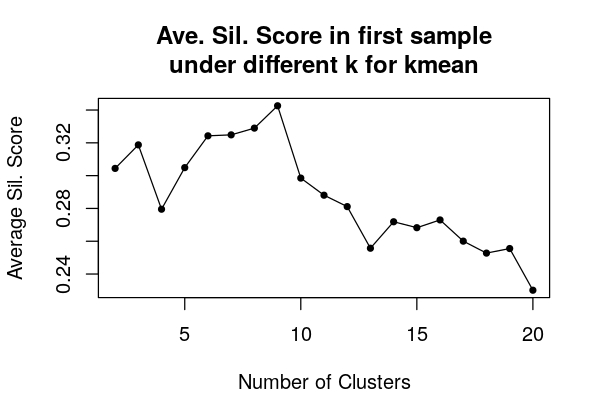

In [287]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
plot(num_clust, x_avg_width, pch = 20, 
     xlab = "Number of Clusters", 
     ylab = "Average Sil. Score",
     main = "Ave. Sil. Score in first sample\nunder different k for kmean")
lines(num_clust, x_avg_width)

# Try pick the best Kmean for each k

In [288]:
get_best_km = function(dat, k, niter = 5, random_state = 0) {
    ### set seed & initialization
    set.seed(random_state)
    avg_width_record = -Inf
    km_best          = NULL
    
    ### get the best kmeans
    for (dummy_num in 1:niter){
        ### kmeans clustering
        km  = kmeans(dat, centers=k, nstart=20, iter.max=30)
        sil = silhouette(km$cluster, dist(dat))
        avg_width = mean(sil[,3])
        
        ### check if it is the best one
        if (avg_width > avg_width_record) {
            avg_width_record = avg_width
            km_best          = km
        } # end if
    } # end for loop
    
    res = list(km_best = km_best, k = k, avg_width = avg_width_record)
    return(res)
} # end function

In [290]:
### initialization
avg_widths = c()
num_clust  = c(5, 7, 9, 10, 11, 13, 15, 17)
dat        = Y1

### try different k in kmeans
for (k in num_clust){
    res = get_best_km(dat, k, random_state = 123)
    avg_widths = c(avg_widths, res$avg_width)
} # end for loop

num_clust[which.max(avg_widths)]

[1] 9

Visualization

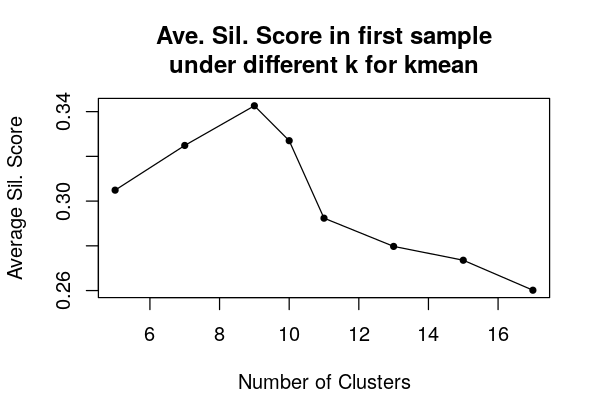

In [291]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
plot(num_clust, avg_widths, pch = 20,
     xlab = "Number of Clusters", 
     ylab = "Average Sil. Score",
     main = "Ave. Sil. Score in first sample\nunder different k for kmean")
lines(num_clust, avg_widths)

# Best Kmeans for each sample and each k

In [292]:
### initialization
lst_km         = list()
lst_avg_widths = list()
num_clust      = seq(from = 2, to = 12, by = 2)

### for each sample
for (idx_sample in unique(Y$label)) {
    
    ### initialization
    dat = Y %>% dplyr::filter(label == idx_sample) %>% dplyr::select(-label)
    avg_widths    = c()
    lst_km_sample = list()
    cat("Sample", idx_sample, "\n")
    
    ### try different k in kmeans
    for (idx_k in 1:length(num_clust)){
        ### kmean clustering
        k = num_clust[idx_k]
        res = get_best_km(dat, k, niter = 5, random_state = 123)
        
        ### record average sil score and store kmean results
        avg_widths = c(avg_widths, res$avg_width)
        lst_km_sample[[idx_k]] = res
    } # end for loop
    
    ### record the results of each sample
    lst_km[[idx_sample]] = lst_km_sample
    lst_avg_widths[[idx_sample]] = avg_widths
} # end for loop

Sample 1 
Sample 2 
Sample 3 
Sample 4 
Sample 5 
Sample 6 
Sample 7 
Sample 8 
Sample 9 
Sample 10 
Sample 11 
Sample 12 
Sample 13 
Sample 14 
Sample 15 
Sample 16 
Sample 17 
Sample 18 


arrange the avg sil score

In [293]:
res = do.call(cbind, lst_avg_widths) %>% as.data.frame
colnames(res) = unique(Y$label)

res$num_clust = num_clust
res = res %>% gather(sample, value, -num_clust)
head(res, 6)

num_clust,sample,value
2,1,0.3044211
4,1,0.2799945
6,1,0.3242855
8,1,0.3382955
10,1,0.3270027
12,1,0.2842577


visualization

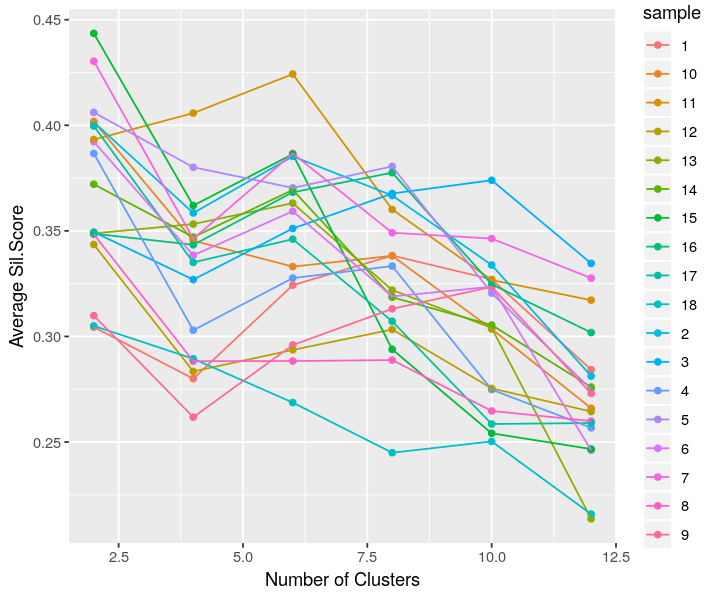

In [294]:
gp  = ggplot(res, aes(x = num_clust, y = value, group = sample, color = sample))
gp  = gp +
    geom_point() +
    geom_line() +
    labs(x = "Number of Clusters", y = "Average Sil.Score")

options(repr.plot.width = 6, repr.plot.height = 5)
print(gp)

# Choose the best k for each sample

In [113]:
### initialization
lst_km_best = list()

### for each sample
for (idx_sample in 1:length(lst_km)){
    
    ### get the km obj and score of each sample
    lst_km_sample = lst_km[[idx_sample]]
    avg_widths    = lst_avg_widths[[idx_sample]]
    
    ### choose the best one based on the score
    idx_k = which.max(avg_widths)
    lst_km_best[[idx_sample]] = lst_km_sample[[idx_k]]
} # end for loop

Check if the code work properly

In [254]:
# number of clusters in each sample
lapply(lst_km_best, function(x){x$k}) %>% as.numeric

[1]  8  2 10  2  2  2  2  2 10  2  6  2  6  2  2  8  2  2

In [120]:
idx = 1
tmp = lst_km_best[[idx]]
unique(tmp$km_best$cluster)

idx = 2
tmp = lst_km_best[[idx]]
unique(tmp$km_best$cluster)

[1] 6 8 4 2 7 1 5 3

[1] 1 2

In [139]:
tmp  = lapply(lst_km_best, function(x){x$km_best$cluster})
tmp2 = do.call(c, tmp)

In [147]:
length(tmp)
length(tmp2)

length(tmp[[1]])
unique(tmp[[1]])
length(tmp[[2]])
unique(tmp[[2]])

[1] 18

[1] 18000

[1] 1000

[1] 6 8 4 2 7 1 5 3

[1] 1000

[1] 1 2

In [149]:
idx = 1
tmp = lst_km_best[[idx]]
dat = Y %>% dplyr::filter(label == idx) %>% dplyr::select(-label)

clustSample1 = ClusteredSample(
    labels = tmp$km_best$cluster, 
    sample = dat)

idx = 2
tmp = lst_km_best[[idx]]
dat = Y %>% dplyr::filter(label == idx) %>% dplyr::select(-label)

clustSample2 = ClusteredSample(
    labels = tmp$km_best$cluster, 
    sample = dat)

idx = 3
tmp = lst_km_best[[idx]]
dat = Y %>% dplyr::filter(label == idx) %>% dplyr::select(-label)

clustSample3 = ClusteredSample(
    labels = tmp$km_best$cluster, 
    sample = dat)

In [150]:
mec = match.clusters(
    clustSample1, 
    clustSample2,
    dist.type="Mahalanobis", 
    unmatch.penalty=99999)

summary(mec)

clusters/meta-clusters      matched clusters/meta-clusters
from sample1/template1      sample2/template2 
           1                            2
           2                            1
           3                            2
           4                            1
           5                            1
           6                            1
           7                            2
           8                            1


# Calibration

In [151]:
tmp = lapply(lst_km_best, function(x){x$km_best$cluster})
tmp = do.call(c, tmp)

dat = Y
dat$clust = tmp
dat = dat %>% group_by(label, claust) %>% summarize_all(mean)
dat

label,clust,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
1,1,-0.873855150,0.568285744,0.52351688,-0.055565422,1.9473248,-0.90281155,0.1782153,1.987999242,0.2722051,1.05259519
1,2,-0.832046962,0.069280780,-0.16945887,0.250882379,2.0610310,0.36500819,-0.2034272,0.186506289,-0.5119270,0.18162535
1,3,-1.183590247,0.084145800,-0.22388457,-0.683994786,1.9280981,-1.43765211,-0.4605925,0.317259622,-0.5139634,0.35031358
1,4,-0.003919812,-0.552412192,1.30737543,-0.346640132,-0.2938386,0.62286781,-0.4204082,0.072505675,-0.4576985,-0.14897607
1,5,-1.200266339,-0.209980147,1.36059730,-0.976020709,1.9241255,0.49934472,-0.1487566,-0.073830659,-0.6714711,0.01041569
1,6,-0.536986379,-0.457787229,-0.49082466,-0.259241502,-0.2018076,-0.88808124,-0.5684967,0.737246357,-0.5217908,-0.14951301
1,7,0.691199749,1.883221722,0.47041503,0.428880985,1.1891023,-0.06411122,0.8300005,1.907793976,2.4853065,1.49706368
1,8,0.217850931,-0.529336874,-0.20141604,1.236015295,-0.2273064,0.53747446,-0.2794551,0.042452211,-0.3979877,-0.16241956
2,1,0.389556212,-0.533403958,-0.08826965,0.125032429,-0.2058711,0.14456983,-0.3830641,-0.629316009,-0.2686884,-0.54379014
2,2,0.367317766,1.062491867,0.40862217,0.233371329,0.8518069,-0.70463937,0.8904798,1.387703084,2.0938944,1.09221285


create clusterSamples object for each sample

In [313]:
### get cluster labels
clust_labels = lapply(lst_km_best, function(x){x$km_best$cluster})
clust_labels = do.call(c, clust_labels)

### add cluster label to Y
Y_clust = Y
Y_clust$clust = clust_labels

###
lst_matrix_samples = lapply(1:length(lst_km_best), function(idx){
    ###
    df = Y_clust %>% dplyr::filter(label == idx) %>% dplyr::select(-label, -clust)
    return(df)
}) # end lapply

lst_clust_samples = lapply(1:length(lst_km_best), function(idx){
    ### get the markers and km clustering
    df = lst_matrix_samples[[idx]]
    km = lst_km_best[[idx]]
    
    ### create ClusteredSample
    clust_sample = ClusteredSample(
        labels = km$km_best$cluster, 
        sample = df)
    
    return(clust_sample)
}) # end lapply

### check the output
length(lst_avg_widths)
length(lst_matrix_samples)
length(lst_clust_samples)
length(lst_km_best)

head(dat, 3)

[1] 18

[1] 18

[1] 18

[1] 18

label,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,clust
1,-0.6455896,-0.5457021,-0.5935153,-0.55472460,-0.2094164,-0.6437814,-0.2853715,1.73466131,-0.41844281,-0.29275305,6
1,0.2244662,-0.1547323,-0.1679703,1.12517242,-0.1450763,0.9418597,-0.4212507,0.09524235,-0.23690905,0.01274202,8
1,-0.4207098,-0.4083593,1.3943065,-0.09351875,-0.1454296,0.5002835,-0.7738127,0.25054915,-0.07758054,-0.18615667,4


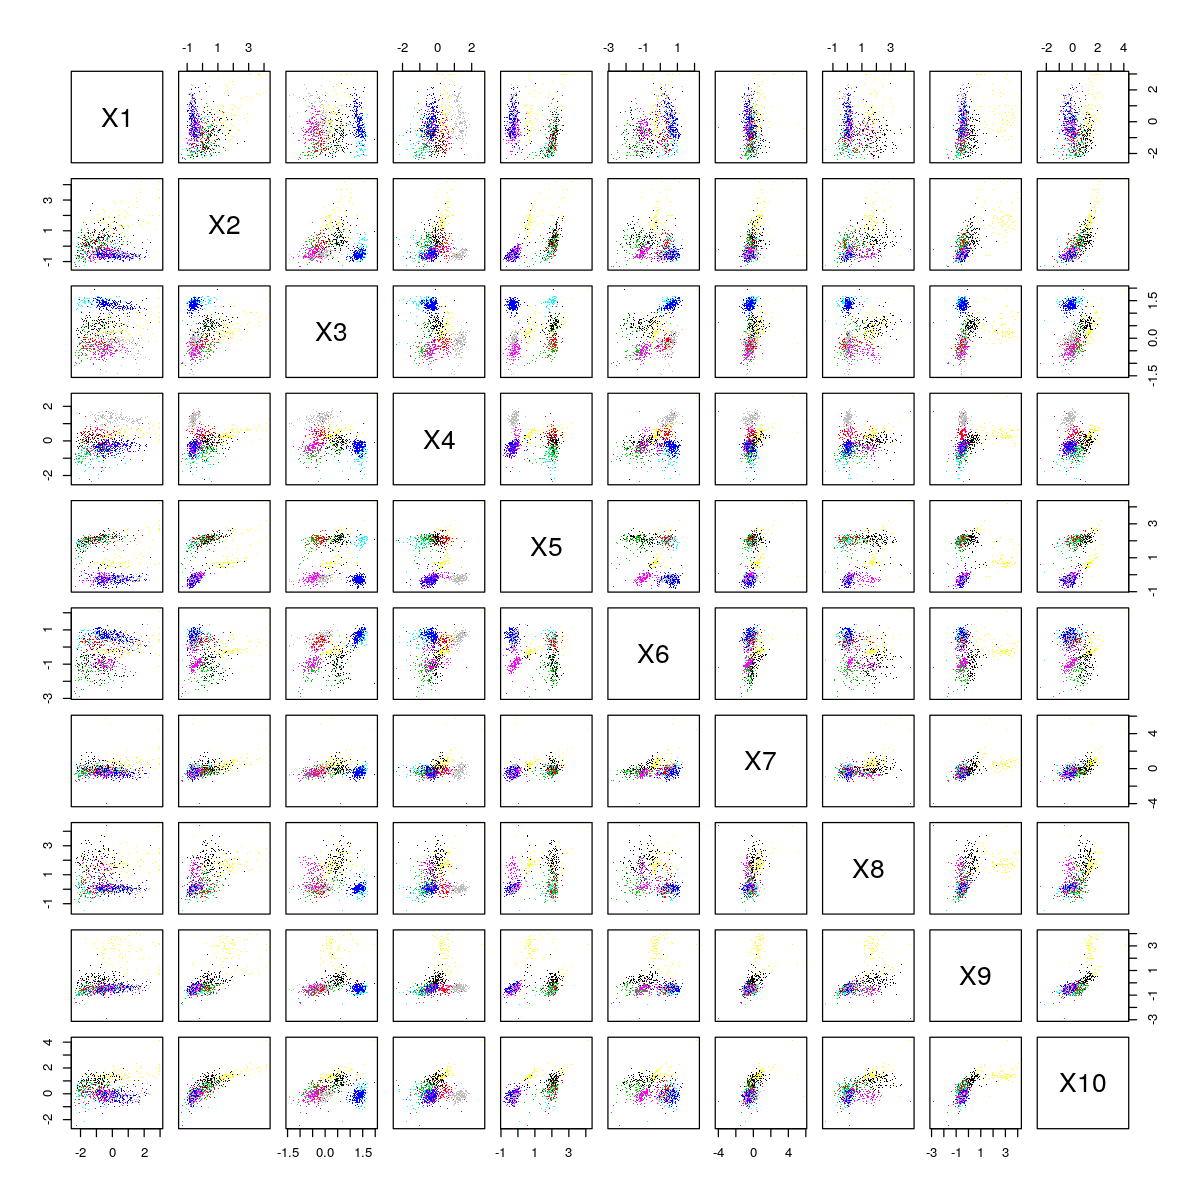

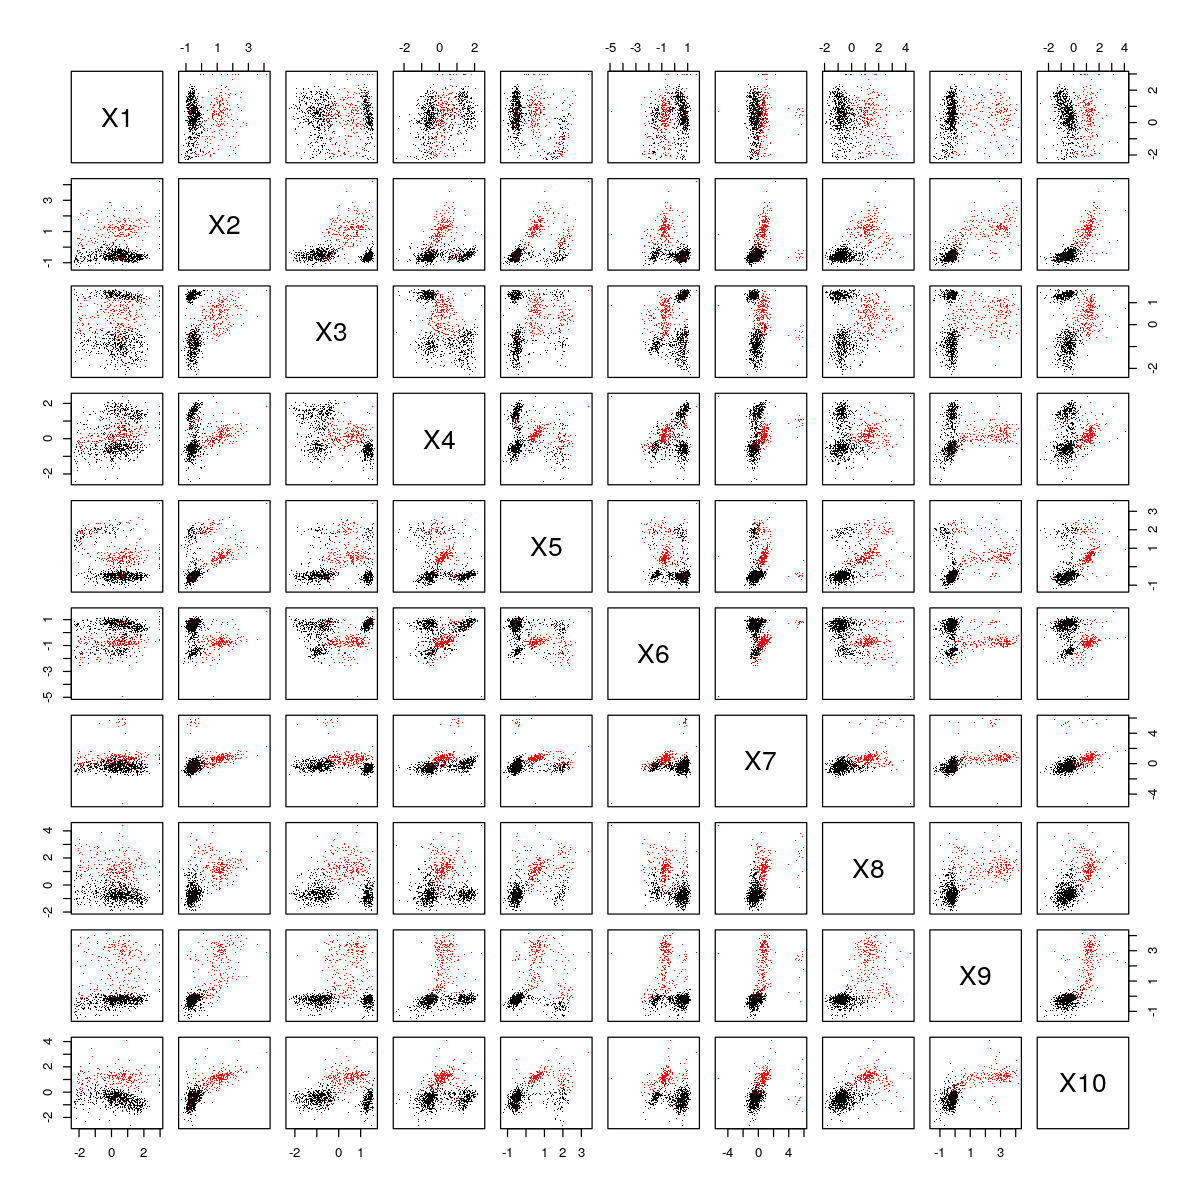

In [314]:
options(repr.plot.width = 10, repr.plot.height = 10)
idx = 1; plot(lst_matrix_samples[[idx]], lst_clust_samples[[idx]])
idx = 2; plot(lst_matrix_samples[[idx]], lst_clust_samples[[idx]])

# compare each sample to the reference

In [323]:
### initialization
clust_ref = lst_clust_samples[[1]]

### compare each sample to the reference
lst_mec = lapply(2:length(lst_clust_samples), function(idx){
    ### initialization
    clust_sam = lst_clust_samples[[idx]]
   
    ### compare
    mec = match.clusters(
        clust_ref, 
        clust_sam,
        dist.type="Mahalanobis", 
        unmatch.penalty=99999)
    return(mec)
}) # end lapply

### check teh output
length(lst_mec)
summary(lst_mec[[1]])

[1] 17

clusters/meta-clusters      matched clusters/meta-clusters
from sample1/template1      sample2/template2 
           1                            2
           2                            1
           3                            2
           4                            1
           5                            1
           6                            1
           7                            2
           8                            1


In [322]:
### get the 
lst_map = lapply(lst_mec, function(mec){
    ### convert mapping to dataframe
    tab = mec@match21
    tab = lapply(1:length(tab), function(idx){
        df = data.frame(clust_sam = idx, clust_ref = tab[[idx]])
    }) # end lapply
    
    ### arrange and return
    tab = do.call(bind_rows, tab)
    return(tab)
})

### check teh output
length(lst_map)
lst_map[[1]]

[1] 17

clust_sam,clust_ref
1,2
1,4
1,5
1,6
1,8
2,1
2,3
2,7


In [ ]:
# Y_clust
lst_mat_cal = lapply(1:length(lst_matrix_samples), function(idx){
    mat = Y_clust
})

In [ ]:
#for (idx_clust in 1:length(tab)){
idx_clust = 1
mapped_clust_ref = tab[[idx_clust]]

#print(idx_clust)
#print(mapped_clust_ref)

tmp_sam = dat_sam %>% 
    group_by(clust_sam) %>% 
    summarize_all(mean)

tmp_ref = dat_ref %>% 
    left_join(., tab, by = "clust_ref") %>% 
    dplyr::select(-clust_ref) %>%
    group_by(clust_sam) %>% 
    summarize_all(mean)

#}

In [255]:
idx = 1
tmp = lst_km_best[[idx]]
dat_ref   = dat %>% dplyr::filter(label == idx)

tmp = dat_ref %>% 
clust_ref = ClusteredSample(
    labels = tmp$km_best$cluster, 
    sample = dat_ref)

dat_ref$clust_ref = lst_km_best[[idx]]$km_best$cluster
#dat_ref$label = idx

##############################

idx = 2
tmp = lst_km_best[[idx]]
dat_sam   = Y %>% dplyr::filter(label == idx) %>% dplyr::select(-label)

clust_sam = ClusteredSample(
    labels = tmp$km_best$cluster, 
    sample = dat_sam)

dat_sam$clust_sam = lst_km_best[[idx]]$km_best$cluster
#dat_ref$label = idx

#############################

mec = match.clusters(
    clustRef, 
    clustSample,
    dist.type="Mahalanobis", 
    unmatch.penalty=99999)

tab = mec@match21
tab = lapply(1:length(tab), function(idx){df = data.frame(clust_sam = idx, clust_ref = tab[[idx]])})
tab = do.call(bind_rows, tab)
tab

clust_sam,clust_ref
1,2
1,4
1,5
1,6
1,8
2,1
2,3
2,7


In [256]:
summary(mec)

clusters/meta-clusters      matched clusters/meta-clusters
from sample1/template1      sample2/template2 
           1                            2
           2                            1
           3                            2
           4                            1
           5                            1
           6                            1
           7                            2
           8                            1


In [191]:
head(dat_sam)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,clust
-0.29864455,-0.4553434,1.482806,-1.0783359,-0.7243474,0.8415445,-0.2393934,-1.0420671,-0.37282411,-0.36635532,1
-0.01312761,-0.4320225,-1.332338,1.4214063,-0.5322419,0.7903658,0.6550780,-0.7561098,-0.15765730,0.05112764,1
0.54219749,-0.1702784,-1.505530,1.8876474,-0.4572215,0.8912883,0.4661504,-0.4343919,-0.02630260,-0.23258709,1
1.75395079,-0.4925016,1.315974,-0.5861990,-0.3522004,0.7067394,-0.4726853,-0.6878027,-0.01055458,-1.13593852,1
1.41928747,-0.4887216,-1.113869,-0.3062884,-0.4057022,-0.4988150,-0.2629025,-0.5182150,-0.05005982,-0.98826644,1
-0.08706039,-0.7247993,1.362004,-0.6932693,-0.9972571,0.9149430,-1.7902915,-1.0053125,-0.65712249,-1.05595132,1


In [189]:
mapped_clust_ref

[1] 2 4 5 6 8

In [212]:
#for (idx_clust in 1:length(tab)){
idx_clust = 1
mapped_clust_ref = tab[[idx_clust]]

#print(idx_clust)
#print(mapped_clust_ref)

tmp_sam = dat_sam %>% 
    group_by(clust_sam) %>% 
    summarize_all(mean)

tmp_ref = dat_ref %>% 
    left_join(., tab, by = "clust_ref") %>% 
    dplyr::select(-clust_ref) %>%
    group_by(clust_sam) %>% 
    summarize_all(mean)

#}

In [216]:
delta = as.matrix(tmp_sam) - as.matrix(tmp_ref)
delta = delta[, -1]
delta

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0.6538798,-0.1138777,-0.5027368,0.05633253,-0.4385167,-0.1202273,-0.01862982,-0.82589881,0.212745,-0.4474849
0.9468081,0.3189106,0.1388964,0.36913032,-0.8984519,0.1590775,0.75366936,-0.04266391,1.517438,0.1536323


In [217]:
head(dat_sam)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,clust_sam
-0.29864455,-0.4553434,1.482806,-1.0783359,-0.7243474,0.8415445,-0.2393934,-1.0420671,-0.37282411,-0.36635532,1
-0.01312761,-0.4320225,-1.332338,1.4214063,-0.5322419,0.7903658,0.6550780,-0.7561098,-0.15765730,0.05112764,1
0.54219749,-0.1702784,-1.505530,1.8876474,-0.4572215,0.8912883,0.4661504,-0.4343919,-0.02630260,-0.23258709,1
1.75395079,-0.4925016,1.315974,-0.5861990,-0.3522004,0.7067394,-0.4726853,-0.6878027,-0.01055458,-1.13593852,1
1.41928747,-0.4887216,-1.113869,-0.3062884,-0.4057022,-0.4988150,-0.2629025,-0.5182150,-0.05005982,-0.98826644,1
-0.08706039,-0.7247993,1.362004,-0.6932693,-0.9972571,0.9149430,-1.7902915,-1.0053125,-0.65712249,-1.05595132,1


In [229]:
-0.4553434 - (-0.1138777)

[1] -0.3414657

In [238]:
dat_sam_cal = apply(dat_sam, 1, function(x){
    idx = x["clust_sam"]
    x[-length(x)] - delta[idx, ]
})

dat_sam_cal = dat_sam_cal %>% t %>% as.data.frame
head(dat_sam_cal, 3)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
-0.9525243,-0.34146579,1.9855432,-1.134668,-0.28583077,0.9617719,-0.2207636,-0.21616832,-0.5855691,0.0811296
-0.6670074,-0.31814488,-0.8296012,1.365074,-0.09372518,0.9105931,0.6737078,0.06978899,-0.3704023,0.4986126
-0.1116823,-0.05640075,-1.0027932,1.831315,-0.01870486,1.0115156,0.4847802,0.39150693,-0.2390476,0.2148978


# TSNE

In [237]:
dat_ori = Y %>% dplyr::filter(label %in% c(1, 2)) %>% dplyr::select(-label)
dat_ori = dat_ori %>% as.matrix
head(dat_ori)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
-0.6455896,-0.54570207,-0.5935153,-0.55472460,-0.2094164,-0.6437814,-0.2853715,1.73466131,-0.41844281,-0.29275305
0.2244662,-0.15473226,-0.1679703,1.12517242,-0.1450763,0.9418597,-0.4212507,0.09524235,-0.23690905,0.01274202
-0.4207098,-0.40835926,1.3943065,-0.09351875,-0.1454296,0.5002835,-0.7738127,0.25054915,-0.07758054,-0.18615667
0.6440377,0.09451951,-0.2382699,0.33526906,2.1359880,0.2413292,-0.2425823,-0.09907509,-0.27055149,-0.07602505
-0.4864461,-0.18420632,-0.2993015,0.24059646,0.1062128,-0.6851305,-0.1626246,1.31013735,-0.45538701,-0.15316494
-1.0666644,0.37590397,-0.2642500,0.56390977,2.0521535,0.5718928,-0.6090580,0.04388268,-0.46684063,0.69473136


In [240]:
print(1)

[1] 1


In [271]:
dim(dat_ref[, 1:10])

[1] 1000   10

In [272]:
dim(dat_sam_cal)

[1] 1000   10

In [241]:
tsne_ori = tsne(dat_ori)

sigma summary: Min. : 0.281824861943124 |1st Qu. : 0.421777488525316 |Median : 0.475390721520207 |Mean : 0.479165498484246 |3rd Qu. : 0.524780126232357 |Max. : 1.0298069771098 |
Epoch: Iteration #100 error is: 15.0446959560518
Epoch: Iteration #200 error is: 1.13408747096399
Epoch: Iteration #300 error is: 0.962668007770908
Epoch: Iteration #400 error is: 0.893181602531454
Epoch: Iteration #500 error is: 0.865931932940056
Epoch: Iteration #600 error is: 0.851365624001887
Epoch: Iteration #700 error is: 0.842258627707238
Epoch: Iteration #800 error is: 0.836073412767208
Epoch: Iteration #900 error is: 0.83160526425009
Epoch: Iteration #1000 error is: 0.828174834064432


In [274]:
dat_cal = rbind(dat_ref[, 1:10], dat_sam_cal)
dim(dat_cal)

[1] 2000   10

In [275]:
tsne_cal = tsne(dat_cal)

sigma summary: Min. : 0.290005727952903 |1st Qu. : 0.405953581105532 |Median : 0.460127373509398 |Mean : 0.469832774310042 |3rd Qu. : 0.519628008105851 |Max. : 1.00966359330759 |
Epoch: Iteration #100 error is: 15.3749700527712
Epoch: Iteration #200 error is: 1.18007099927953
Epoch: Iteration #300 error is: 1.01133923080712
Epoch: Iteration #400 error is: 0.943813795604357
Epoch: Iteration #500 error is: 0.917848292615343
Epoch: Iteration #600 error is: 0.904229522577349
Epoch: Iteration #700 error is: 0.895961016018679
Epoch: Iteration #800 error is: 0.890410533568308
Epoch: Iteration #900 error is: 0.886470601618089
Epoch: Iteration #1000 error is: 0.883540324717344


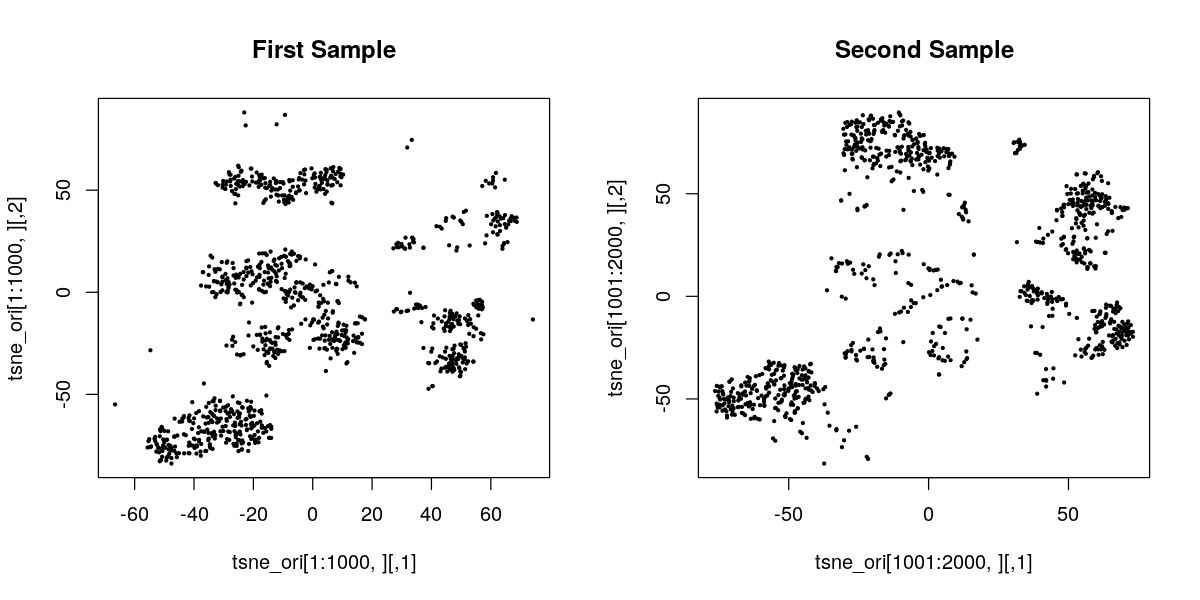

In [261]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))

plot(tsne_ori[1:1000,    ], pch = 20, cex = 0.5, main = "First Sample")
plot(tsne_ori[1001:2000, ], pch = 20, cex = 0.5, main = "Second Sample")

In [263]:
dim(tsne_cal)

[1] 1000    2

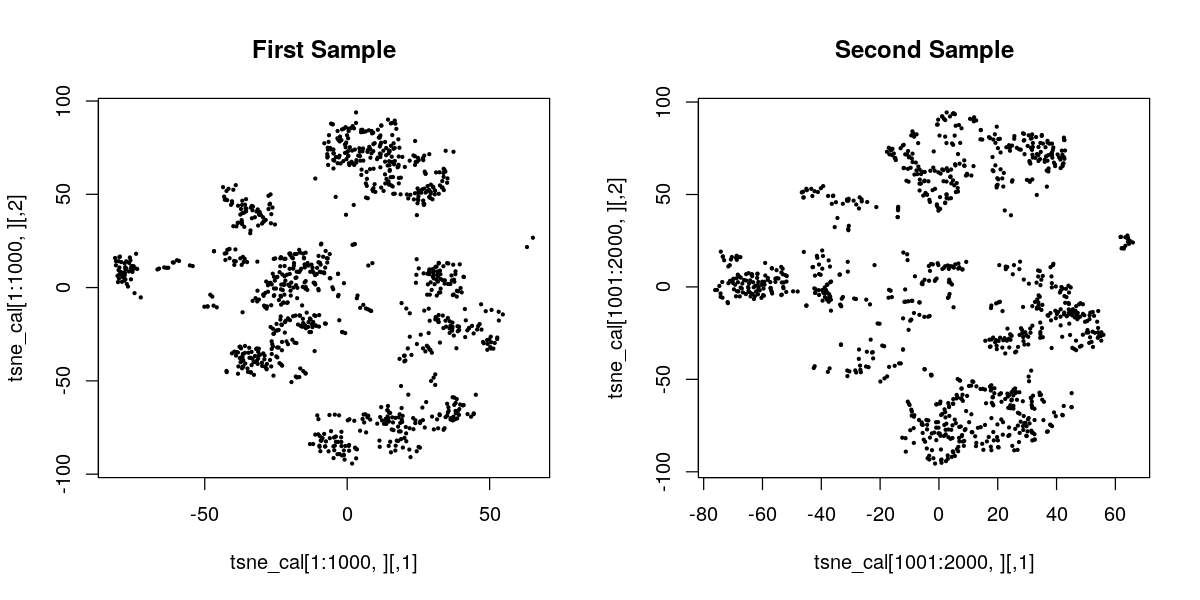

In [276]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))

plot(tsne_cal[1:1000,    ], pch = 20, cex = 0.5, main = "First Sample")
plot(tsne_cal[1001:2000, ], pch = 20, cex = 0.5, main = "Second Sample")

# TSNE

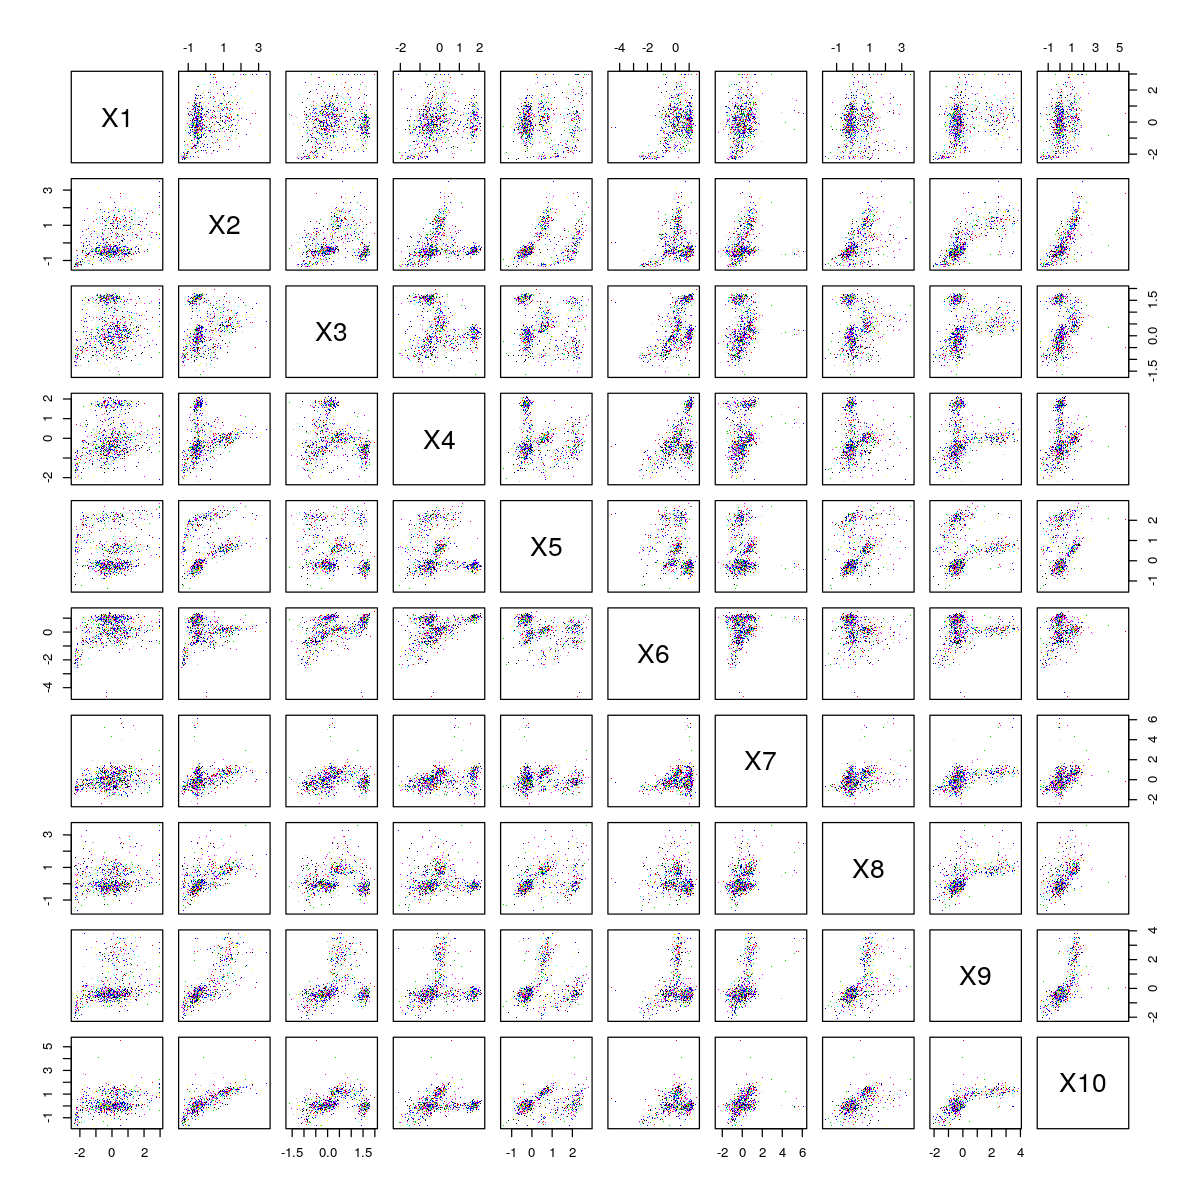

In [126]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(dat, clustSample1)

In [92]:
slotNames(clustSample1)

[1] "num.clusters" "labels"       "clusters"     "dimension"    "size"        
[6] "sample.id"